In [1]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import geopandas as gpd
import glob
from PIL import Image 

In [2]:
# set the filepath
fp = "Shape_Files\\India_Districts_2020\\India_Districts.shp"
#read the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is a GEOdataframe
map_df.head()

,dtname,stname,stcode11,dtcode11,year_stat,Dist_LGD,State_LGD,JID,geometry
0,Kupwara,JAMMU & KASHMIR,01,001,2011_c,8.0,1.0,598,"POLYGON ((74.33744 34.78209, 74.34695 34.78019..."
1,Bandipore,JAMMU & KASHMIR,01,009,2011_c,623.0,1.0,599,"POLYGON ((74.73338 34.67121, 74.74956 34.66883..."
2,Baramula,JAMMU & KASHMIR,01,008,2011_c,3.0,1.0,600,"POLYGON ((74.51946 34.42533, 74.52090 34.42237..."
3,Ganderbal,JAMMU & KASHMIR,01,011,2011_c,626.0,1.0,601,"POLYGON ((74.94144 34.46384, 74.94554 34.46247..."
4,Anantnag,JAMMU & KASHMIR,01,014,2011_c,1.0,1.0,602,"POLYGON ((75.26949 34.25584, 75.27242 34.25356..."


<AxesSubplot:>

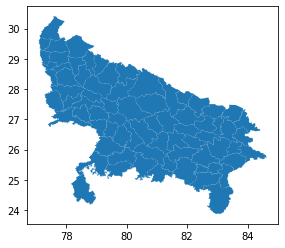

In [3]:
#Isolate the UP districts
map_df_up = map_df[map_df['stname'] == 'UTTAR PRADESH']

#Check the resulting UP Plot
map_df_up.plot()

In [4]:
#Get the data CSV file
df = pd.read_csv('Data\\UP_dummy_data.csv')
df.head()

,Tractor Model,Installed On,installation_state,installation_district
0,MAHINDRA ARJUN Ultra 605 DI-57HP,2019-10-12T12:49:38.554Z,Uttar Pradesh,Aligarh
1,MAHINDRA BHOOMIPUTRA 265 DI-35 HP,2019-10-14T09:15:07.407Z,Uttar Pradesh,Aligarh
2,MAHINDRA BHOOMIPUTRA 265 DI-35 HP,2019-10-14T11:24:34.931Z,Uttar Pradesh,Aligarh
3,MAHINDRA BHOOMIPUTRA 265 DI-35 HP,2019-11-26T06:20:57.740Z,Uttar Pradesh,Aligarh
4,MAHINDRA ARJUN Ultra 1 555 DI-50 HP,2020-01-09T09:40:19.475Z,Uttar Pradesh,Aligarh


In [5]:
#Get district wise installation count
df_district = df['installation_district'].value_counts().to_frame()
df_district.reset_index(inplace=True)
df_district.columns = ['district','count']
df_district.head()

,district,count
0,Meerut,28
1,Azamgarh,27
2,Lakhimpur Kheri,17
3,Kanpur,15
4,Sonbhadra,15


In [6]:
#Merge the districts df with the geopandas df
merged = map_df_up.set_index('dtname').join(df_district.set_index('district'))
merged.head()

,stname,stcode11,dtcode11,year_stat,Dist_LGD,State_LGD,JID,geometry,count
dtname,,,,,,,,,
Amroha,UTTAR PRADESH,09,137,2011_c,154.0,9.0,194,"POLYGON ((78.07308 29.08236, 78.07308 29.08236...",NaN
Hapur,UTTAR PRADESH,09,705,update2014,661.0,9.0,198,"POLYGON ((78.04630 28.88387, 78.04740 28.88388...",NaN
Bareilly,UTTAR PRADESH,09,150,2011_c,130.0,9.0,201,"POLYGON ((79.41858 28.90119, 79.41971 28.90089...",5.0
Pilibhit,UTTAR PRADESH,09,151,2011_c,173.0,9.0,202,"POLYGON ((79.81967 28.88726, 79.82096 28.88680...",4.0
Bulandshahr,UTTAR PRADESH,09,142,2011_c,134.0,9.0,205,"POLYGON ((77.96301 28.71528, 77.96318 28.71511...",NaN


In [7]:
#Fill NA values
merged['count'].fillna(0,inplace=True)
#Get max count
max_installs = merged['count'].max()

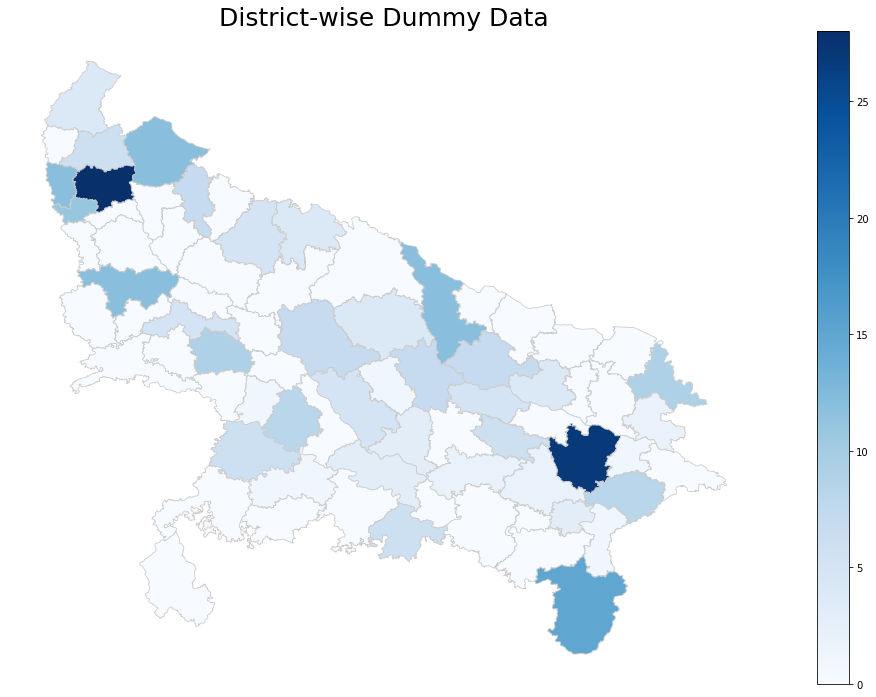

In [8]:
#Generate the choropleth map
fig, ax = plt.subplots(1, figsize=(20, 12))
merged.plot(column='count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
# remove the axis
ax.axis('off')
# add a title
ax.set_title('District-wise Dummy Data', fontdict={'fontsize': '25', 'fontweight' : '3'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=max_installs))
# add the colorbar to the figure
cbar = fig.colorbar(sm)

# Generating a number of choropleth maps to stitch to form a video

In [9]:
#We've seen how to generate a standalone choropleth map using geopandas
#Now we'll attempt to generate a number of such maps and stitch them together
#to form an animated video
df['Installed On'] = df['Installed On'].apply(lambda x: x.split('T')[0])
df['Installed On'] = pd.to_datetime(df['Installed On'],format="%Y-%m-%d")
df.head()

,Tractor Model,Installed On,installation_state,installation_district
0,MAHINDRA ARJUN Ultra 605 DI-57HP,2019-10-12,Uttar Pradesh,Aligarh
1,MAHINDRA BHOOMIPUTRA 265 DI-35 HP,2019-10-14,Uttar Pradesh,Aligarh
2,MAHINDRA BHOOMIPUTRA 265 DI-35 HP,2019-10-14,Uttar Pradesh,Aligarh
3,MAHINDRA BHOOMIPUTRA 265 DI-35 HP,2019-11-26,Uttar Pradesh,Aligarh
4,MAHINDRA ARJUN Ultra 1 555 DI-50 HP,2020-01-09,Uttar Pradesh,Aligarh


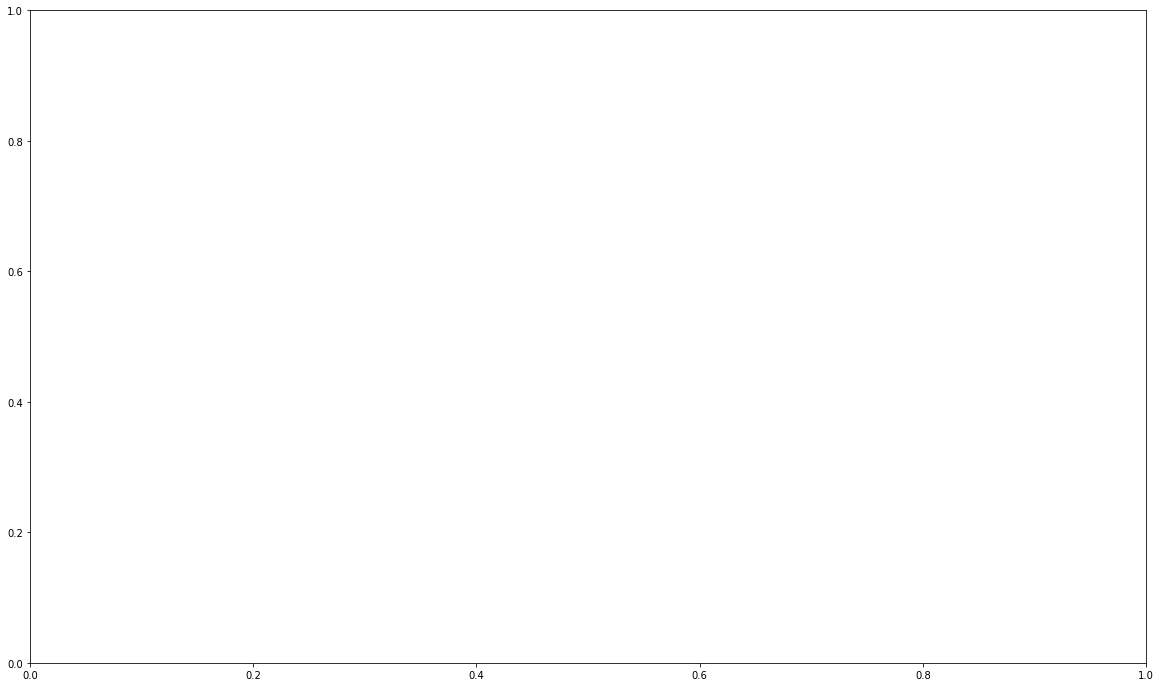

In [10]:
date_min = df['Installed On'].min()
n_days = df['Installed On'].nunique()

fig, ax = plt.subplots(1, figsize=(20, 12))

for i in range(0,n_days):
    date = date_min+timedelta(days=i)
    
    #Get cumulative df till that date
    df_c = df[df['Installed On'] <= date]
    
    #Generate the temporary df
    df_t = df_c['installation_district'].value_counts().to_frame()
    df_t.reset_index(inplace=True)
    df_t.columns = ['dist','count']
    
    #Get the merged df
    df_m = map_df_up.set_index('dtname').join(df_t.set_index('dist'))
    df_m['count'].fillna(0,inplace=True)
    fig, ax = plt.subplots(1, figsize=(20, 12))
    df_m.plot(column='count',
                cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
    # remove the axis
    ax.axis('off')
    # add a title
    ax.set_title('District-wise Dummy Data', 
                 fontdict={'fontsize': '25', 'fontweight' : '3'})
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Blues', 
            norm=plt.Normalize(vmin=0, vmax=df_t['count'].iloc[0]))
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)
    fontsize = 36
    
    # Positions for the date
    date_x = 82
    date_y = 29

    ax.text(date_x, date_y, 
            f"{date.strftime('%b %d, %Y')}", 
            color='black',
            fontsize=fontsize)
    fig.savefig(f"Frames/frame_{i:03d}.png", 
                dpi=100, bbox_inches='tight')
    plt.close()


In [11]:
def png_to_gif(path_to_images, save_file_path, duration=500):
    frames = []
    
    # Retrieve image files
    images = glob.glob(f'{path_to_images}')
    
    # Loop through image files to open, resize them and append them to frames
    for i in sorted(images): 
        im = Image.open(i)
        im = im.resize((1221,969),Image.ANTIALIAS)
        frames.append(im.copy())
        
    # Save frames/ stitched images as .gif
    frames[0].save(f'{save_file_path}', format='GIF', 
                   append_images=frames[:], save_all=True,
                   duration=duration, loop=0)

In [12]:
png_to_gif(path_to_images='Frames/*.png', 
           save_file_path='Frames/frame_.gif',
           duration=500)